****Mount Drive****

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


****Setting Project Workspace****

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/session11')


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

from dataloader import dataset_loader
from evaluation import test
from learning_rate_finder import LRRangeFinder
from models import modified_resnet
from training import train

from cam.gradcam import GradCAM
from cam.utils import visualize_cam, Normalize


  pip install torch-lr-finder -v --global-option="amp"


In [0]:
def show_img(img):
    # plt.figure(figsize=(8,8))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

****Loading data****

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

## getting training data loader
trainloader = dataset_loader.get_dataloader(True, cuda)
## getting test data loader
testloader = dataset_loader.get_dataloader(False, cuda)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


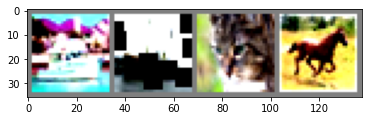

GroundTruth:   ship  ship   cat horse


In [6]:
#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# show images
show_img(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

****Initializing Network Architecture****

In [7]:
mod = modified_resnet.s11DNN().to(device)

#mod = resnet.ResNet18().to(device)
summary(mod, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
 ModifiedResBlock-14          [-1, 128,

##LR Range Finder


Learning rate search finished. See the graph with {finder_name}.plot()


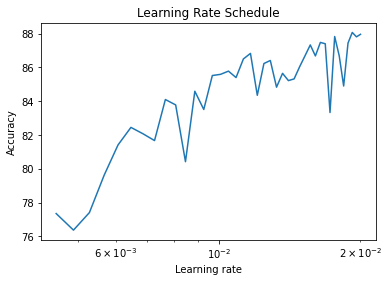

In [11]:
%%time
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.001, momentum=0.90)
lr_finder =  LRRangeFinder(mod, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-4, end_lr=0.02, epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()


# criterion = nn.NLLLoss()
# optimizer = optim.SGD(mod.parameters(), lr=0.001, momentum=0.90)
# lr_finder = LRRangeFinder(mod, optimizer, criterion, device=device)
# lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-4, end_lr=0.02, epochs=50, step_mode="linear")
# lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
# lr_finder.reset()


In [12]:
#best_loss = lr_finder.best_loss
#best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
#print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))


best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 88.07
Best Learning Rate: 0.019208061224489797


## Plot triangular LR

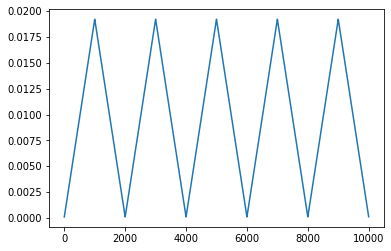

In [17]:
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

# Demo of how the LR varies with iterations
num_iterations = 10000
stepsize = 1000
base_lr = 0.0001
max_lr = best_lr
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)

plt.plot(lr_trend)

# Model Training and Evaluation

In [19]:
%%time
#optimizer = optim.SGD(mod.parameters(), lr=best_lr, momentum=0.99)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader), epochs=24, div_factor=10, final_div_factor=1,pct_start=5/24, anneal_strategy="linear")

# Model Training and Evaluation
train_losses, train_accuracy, test_losses, test_accuracy, misclassified_images = [], [], [], [], []
for epoch in range(0, 24):
    train_losses, train_accuracy = train.train(mod, device, trainloader, optimizer, epoch, criterion, train_losses, train_accuracy)
    test_losses, test_accuracy, accuracy, misclassified_images = test.test(mod, device, testloader, criterion, test_losses, test_accuracy, misclassified_images)
    scheduler.step(accuracy)

epoch=0 Loss=1.4907485246658325 Batch_id=97 Accuracy=46.84: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5502/10000 (55.0%)



epoch=1 Loss=1.0903412103652954 Batch_id=97 Accuracy=55.51: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6538/10000 (65.4%)



epoch=2 Loss=0.9875141978263855 Batch_id=97 Accuracy=63.34: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6931/10000 (69.3%)



epoch=3 Loss=0.8367699384689331 Batch_id=97 Accuracy=68.36: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7363/10000 (73.6%)



epoch=4 Loss=0.8294529914855957 Batch_id=97 Accuracy=70.86: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7701/10000 (77.0%)



epoch=5 Loss=0.7418703436851501 Batch_id=97 Accuracy=73.98: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7699/10000 (77.0%)



epoch=6 Loss=0.5980885624885559 Batch_id=97 Accuracy=75.85: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8094/10000 (80.9%)



epoch=7 Loss=0.6388124227523804 Batch_id=97 Accuracy=77.71: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7992/10000 (79.9%)



epoch=8 Loss=0.61113041639328 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8187/10000 (81.9%)



epoch=9 Loss=0.5546904802322388 Batch_id=97 Accuracy=79.89: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8269/10000 (82.7%)



epoch=10 Loss=0.5699856877326965 Batch_id=97 Accuracy=81.00: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8297/10000 (83.0%)



epoch=11 Loss=0.5724591016769409 Batch_id=97 Accuracy=82.59: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8458/10000 (84.6%)



epoch=12 Loss=0.4513791501522064 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8516/10000 (85.2%)



epoch=13 Loss=0.5753673315048218 Batch_id=97 Accuracy=84.08: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8238/10000 (82.4%)



epoch=14 Loss=0.5669177770614624 Batch_id=97 Accuracy=84.56: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8509/10000 (85.1%)



epoch=15 Loss=0.35534167289733887 Batch_id=97 Accuracy=85.82: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8535/10000 (85.3%)



epoch=16 Loss=0.34391361474990845 Batch_id=97 Accuracy=86.23: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8636/10000 (86.4%)



epoch=17 Loss=0.3382273316383362 Batch_id=97 Accuracy=86.61: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8704/10000 (87.0%)



epoch=18 Loss=0.3573557734489441 Batch_id=97 Accuracy=86.91: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8607/10000 (86.1%)



epoch=19 Loss=0.3886101245880127 Batch_id=97 Accuracy=87.61: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8654/10000 (86.5%)



epoch=20 Loss=0.32115501165390015 Batch_id=97 Accuracy=89.01: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8740/10000 (87.4%)



epoch=21 Loss=0.34959205985069275 Batch_id=97 Accuracy=89.03: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8689/10000 (86.9%)



epoch=22 Loss=0.3291935920715332 Batch_id=97 Accuracy=88.96: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8669/10000 (86.7%)



epoch=23 Loss=0.2421649694442749 Batch_id=97 Accuracy=90.11: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.0009, Accuracy: 8711/10000 (87.1%)

CPU times: user 3min 41s, sys: 2min 38s, total: 6min 20s
Wall time: 12min 54s


## Visualising train and test accuracy

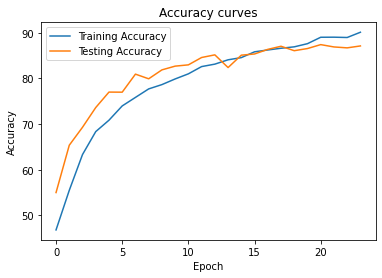

In [20]:
plt.figure()
ax = plt.subplot(111)
ax.plot(train_accuracy)
ax.plot(test_accuracy)
ax.set(title="Accuracy curves", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.show()

## Gradcam implementation for misclassified images

In [22]:
resnet_model_dict = dict(type='resnet', arch=mod, layer_name='layer3', input_size=(32, 32))
gradcam = GradCAM(resnet_model_dict, True)

saliency_map size : torch.Size([4, 4])


Actucal: car, Predicted: plane


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


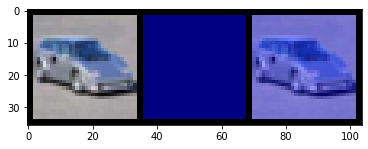

Actucal: bird, Predicted: frog


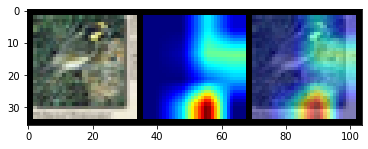

Actucal: bird, Predicted: frog


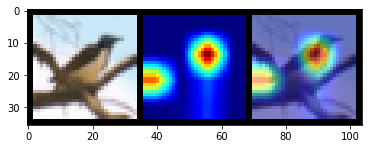

Actucal: dog, Predicted: deer


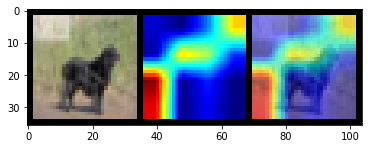

Actucal: bird, Predicted: deer


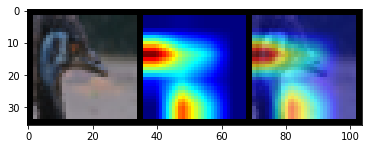

Actucal: plane, Predicted: ship


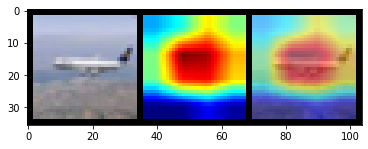

Actucal: plane, Predicted: ship


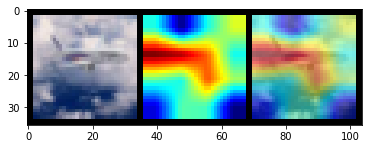

Actucal: dog, Predicted: cat


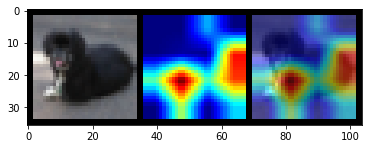

Actucal: bird, Predicted: cat


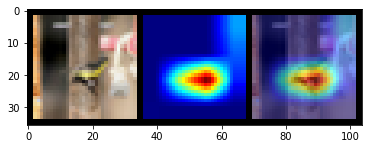

Actucal: dog, Predicted: bird


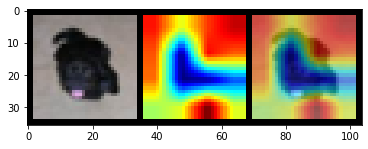

Actucal: bird, Predicted: deer


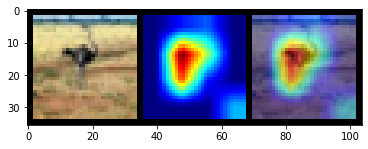

Actucal: deer, Predicted: horse


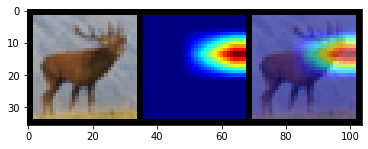

Actucal: car, Predicted: truck


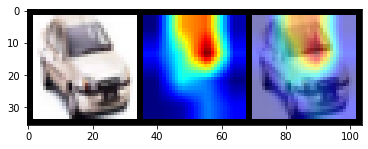

Actucal: car, Predicted: truck


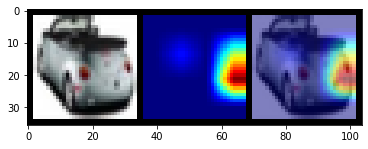

Actucal: deer, Predicted: frog


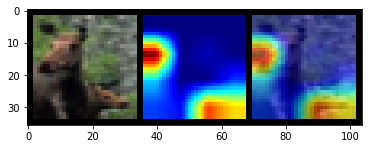

Actucal: ship, Predicted: truck


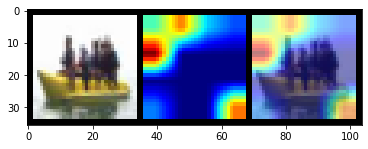

Actucal: bird, Predicted: frog


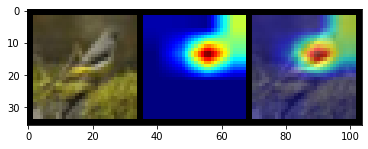

Actucal: bird, Predicted: cat


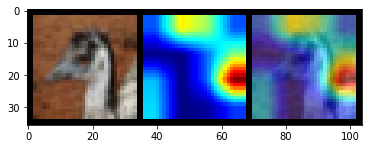

Actucal: deer, Predicted: horse


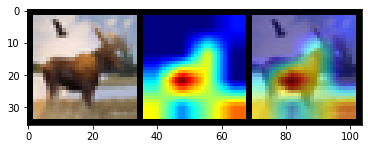

Actucal: bird, Predicted: deer


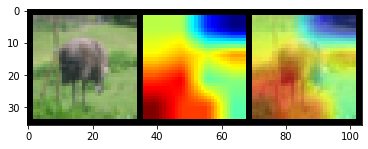

Actucal: cat, Predicted: truck


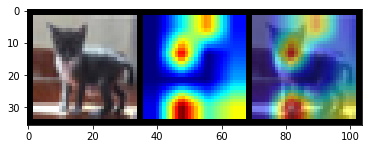

Actucal: horse, Predicted: deer


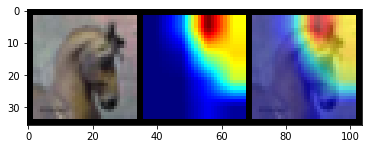

Actucal: cat, Predicted: horse


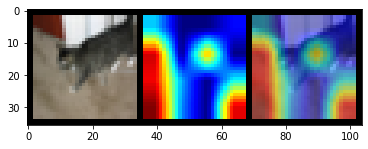

Actucal: bird, Predicted: deer


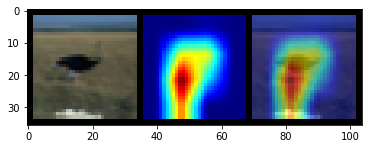

Actucal: bird, Predicted: deer


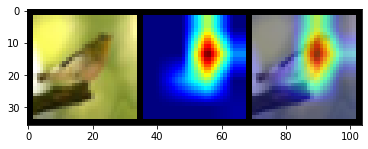

In [23]:
num_img = 25
normalizer = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

for idx in range(num_img):
  output_img = []
  grid_image = ''
  out_img = ''
  
  normed_torch_img = misclassified_images[0]['mis_img'][idx].unsqueeze(0)       # converting 3d to 4d img tensor for gradcam.
  torch_img = normalizer.undo(normed_torch_img)                                 
  target_class = misclassified_images[0]['target_class'][idx]
  pred_class = misclassified_images[0]['predicted_class'][idx]

  ## initialize gradcam layer
  mask, _ = gradcam(normed_torch_img)

  ## visualize gradcam
  heatmap, result = visualize_cam(mask.cpu(), torch_img)
  output_img.extend([torch_img.squeeze(0).cpu(), heatmap, result])
  grid_image = make_grid(output_img, nrow=3) 
  out_img = transforms.ToPILImage()(grid_image)
  print("Actucal: {}, Predicted: {}".format(classes[target_class], classes[pred_class]))
  plt.imshow(out_img)
  plt.pause(0.0001)
  

